# EDA

Ya con los datos completos se procede a realizar el analisis exploratorio de la base de datos.

In [1]:
# Importacion de librerías
import pandas as pd
import numpy as np
import janitor
import matplotlib.pyplot as plt
import seaborn as sns

import os


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
#import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
#from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


#Permite ver en los resultados todas las columnas y las filas, Grupo Marianita, Herdiz, Erick
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')


In [4]:
path = "../data/interim/"
archivo = "datos_completos.csv"

data = pd.read_csv(os.path.join(path,archivo),sep=',')
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [5]:
df = data.clean_names()
df.shape

(7032, 21)

In [6]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   object 
 4   dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   object 
 7   multiplelines     7032 non-null   object 
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   object 
 10  onlinebackup      7032 non-null   object 
 11  deviceprotection  7032 non-null   object 
 12  techsupport       7032 non-null   object 
 13  streamingtv       7032 non-null   object 
 14  streamingmovies   7032 non-null   object 
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   object 


### 1° Variable Objetivo churn

Cambiaremos los valores de la variable Churn a los valores 1 y 0.
Utilizar la función replace() con un diccionario de mapeo

In [9]:
# 1° Cambiaremos los valores de la variable Churn a los valores 1 y 0
# Utilizar la función replace() con un diccionario de mapeo

df['churn'] = df['churn'].replace({'Yes': 1, 'No': 0})

In [10]:
# diatribución de varible Churn
df['churn'].value_counts()

churn
0    5163
1    1869
Name: count, dtype: int64

In [12]:
print('Distribución del variable churn')
df['churn'].value_counts('%')*100

Distribución del variable churn


churn
0   73.42
1   26.58
Name: proportion, dtype: float64

Representación Gráfica de variable objetivo 'churn'

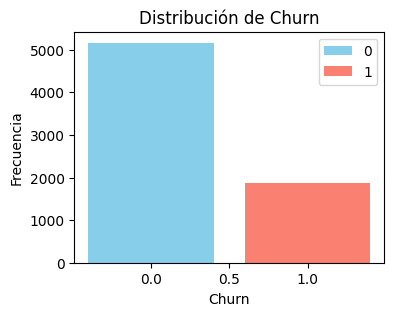

In [14]:
# Gráfico de la variable Churn
plt.figure(figsize=(4, 3))

churn_values = df['churn'].value_counts()
churn_values.values

plt.bar(churn_values.index, churn_values.values, color=['skyblue', 'salmon'], label = churn_values.index)
# Configurar etiquetas y título
plt.xlabel('Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de Churn')
plt.legend(churn_values.index)
# Mostrar el gráfico
plt.show()